# Predicting Movie Rental Durations

In this project, I recommend a regression model (based on the `mean_squared_error` metric) to predict how long a customer rents a DVD from a DVD rental company.

The idea and dataset for this project are from [this DataCamp project](https://app.datacamp.com/learn/projects/predicting-movie-rental-durations/guided/Python).

## The dataset

The data is in the csv file `rental_info.csv`. It has the following features:
- `"rental_date"`: The date (and time) the customer rents the DVD.
- `"return_date"`: The date (and time) the customer returns the DVD.
- `"amount"`: The amount paid by the customer for renting the DVD.
- `"amount_2"`: The square of `"amount"`.
- `"rental_rate"`: The rate at which the DVD is rented for.
- `"rental_rate_2"`: The square of `"rental_rate"`.
- `"release_year"`: The year the movie being rented was released.
- `"length"`: Lenght of the movie being rented, in minuites.
- `"length_2"`: The square of `"length"`.
- `"replacement_cost"`: The amount it will cost the company to replace the DVD.
- `"special_features"`: Any special features, for example trailers/deleted scenes that the DVD also has.
- `"NC-17"`, `"PG"`, `"PG-13"`, `"R"`: These columns are dummy variables of the rating of the movie. It takes the value 1 if the move is rated as the column name and 0 otherwise. For your convinience, the reference dummy has already been dropped.

## Load and inspect data

In [38]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [20]:
# Load and inspect data
movies_df = pd.read_csv("rental_info.csv")
print(movies_df.info())
movies_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15861 entries, 0 to 15860
Data columns (total 15 columns):
rental_date         15861 non-null object
return_date         15861 non-null object
amount              15861 non-null float64
release_year        15861 non-null float64
rental_rate         15861 non-null float64
length              15861 non-null float64
replacement_cost    15861 non-null float64
special_features    15861 non-null object
NC-17               15861 non-null int64
PG                  15861 non-null int64
PG-13               15861 non-null int64
R                   15861 non-null int64
amount_2            15861 non-null float64
length_2            15861 non-null float64
rental_rate_2       15861 non-null float64
dtypes: float64(8), int64(4), object(3)
memory usage: 1.8+ MB
None


,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,special_features,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2
0,2005-05-25 02:54:33+00:00,2005-05-28 23:40:33+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
1,2005-06-15 23:19:16+00:00,2005-06-18 19:24:16+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
2,2005-07-10 04:27:45+00:00,2005-07-17 10:11:45+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
3,2005-07-31 12:06:41+00:00,2005-08-02 14:30:41+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
4,2005-08-19 12:30:04+00:00,2005-08-23 13:35:04+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401


## Exploratory data analysis

We'll change the `rental_date` and `return_date` columns into datetime objects.

We'll encode the `special_features` column into two numerical: `deleted_scenes` and `behind_the_scenes`. To do this, all rows where the `special_features` column contains the string `"Deleted Scenes"` will have a `1` entry in the `deleted_scenes` column, while the rest of the rows of this column will have a `0` entry. Similarly, all rows where the `special_features` column contains the string `"Behind the Scenes"` will have a `1` entry in the `behind_the_scenes` column, while the rest of the rows will have a `0` entry.

## Transform time columns and create `rental_length_days` column

In [21]:
# Get date part of `rental_date` and `return_date` and change to datetime object
movies_df["rental_date"] = movies_df["rental_date"].str.split(" ", expand=True)[0]
movies_df["return_date"] = movies_df["return_date"].str.split(" ", expand=True)[0]

movies_df["rental_date"] = pd.to_datetime(movies_df["rental_date"])
movies_df["return_date"] = pd.to_datetime(movies_df["return_date"])

In [22]:
# Create `rental_length_days`
movies_df["rental_length_days"] = (movies_df["return_date"] - movies_df["rental_date"]).dt.days

## Create `deleted_scenes` and `behind_the_scenes` columns

In [29]:
movies_df["deleted_scenes"] = np.where(movies_df["special_features"].str.contains("Deleted Scenes"), 1, 0)
movies_df["behind_the_scenes"] = np.where(movies_df["special_features"].str.contains("Behind the Scenes"), 1, 0)

In [30]:
movies_df.head()

,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,special_features,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2,rental_length_days,deleted_scenes,behind_the_scenes
0,2005-05-25,2005-05-28,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,3,0,1
1,2005-06-15,2005-06-18,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,3,0,1
2,2005-07-10,2005-07-17,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,7,0,1
3,2005-07-31,2005-08-02,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,2,0,1
4,2005-08-19,2005-08-23,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,4,0,1


# Split data into feature and target variables

Let's split the data into features (`X`) and target (`y`). The target variable is the `rental_length_days` column, so it won't be part of the features.

We'll drop the `special_features` column, since we have encoded it, as well as the `rental_date` and `return_date`, since the target is dependent on them (that is, to avoid leakage). Leakage minimizes your model's ability to generalize to other data.

To avoid multicollinearity, let's also drop the squared columns (`amount_2`, `length_2` and `rental_rate_2`), each of which is highly correlated with the corresponding non-squared column (`amount`, `length` or `rental_rate`). Multicollinearity may present an issue if you want to know which of your features have the greater influence on your model performance.

We'll first drop the target and leakage columns. Then we'll confirm, using a heatmap, that the multicollinear columns are indeed highly correlated before dropping them.

In [47]:
# Drop the leakage and target columns
X = movies_df.select_dtypes("number").drop("rental_length_days", axis="columns")
y = movies_df["rental_length_days"]

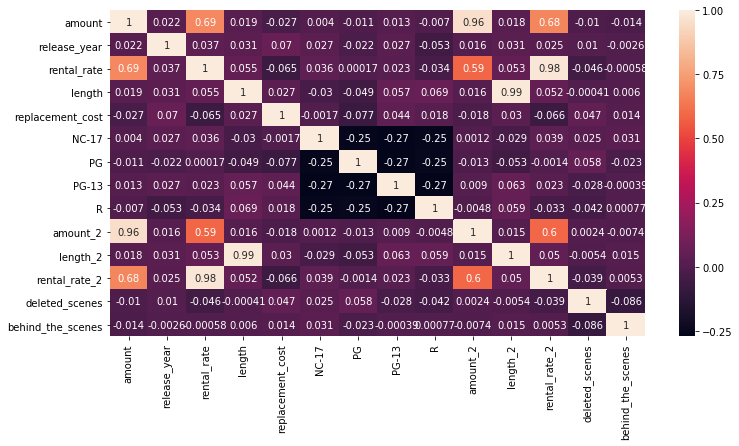

In [48]:
# Visualize correlations
fig, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(X.corr(), ax=ax, annot=True);

The corresponding multicollinear columns have correlations close to 1.

## Split data into train and test sets

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

## Evaluate models

There are a plethora of models we can choose from, but we'll limit our choices to the more popular *linear*, *decision tree* and *random forest* regression models. We'll train these models with their default parameter values (except for the `random_state` parameter) and evaluate the *mean squared error* for each. Based on this metric (mean squared error), we will choose the best-performing model (that is, the model with the least mean squared error), tune the hyperparameters of this model to obtain their optimum values, and then use this optimum hyperparameter values to build a final, optimum model.